# 베이스라인 모델

In [1]:
import xml.etree.ElementTree as elemTree
import os
import sys
tree = elemTree.parse(r'../config/.config.xml')
root = tree.getroot()
xx = root.find('./PATHS')
work_path = xx.find('work').text
sys.path.append(work_path)

In [2]:
import numpy
import talib
from miscs.config_manager import ConfigManager
import pandas as pd
from sqlalchemy import create_engine
from tqdm.auto import tqdm
from realtime_kiwoom.data_provider import *
import re
import numpy as np
import plotly.express as px

c:\Anaconda3\envs\py310_64\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cm = ConfigManager('../config/.config.xml')

# 데이터 로딩

In [4]:
history_provider = MinuteChartDataProvider.Factory(cm, tag='history')

In [5]:
%%time
history_minute_dic = history_provider.get_history_from_ndays_ago(n_days=365)

CPU times: total: 34.3 s
Wall time: 34.5 s


# 기술적 지표

MACD
- macd: 범위제한 없음
- macdsignal: 범위제한 없음
- macdhist: 범위제한 없음

RSI
- rsi: 범위제한 있음

AD Line
- ad: 범위 제한 없음


offset_intra_day
- 9시부터 15시30분사이에 오프셋이 차지하는 위치를 [0, 1] 사이의 값으로 표현

In [6]:
def make_basic_features(df: pd.DataFrame):
  """
  df가 변형됨
  """
  ma = talib.MA(df['close'], timeperiod=30)
  macd, macdsignal, macdhist = talib.MACD(df['close'])
  rsi = talib.RSI(df['close'], timeperiod=14)
  ad = talib.AD(df['high'], df['low'], df['close'], df['volume'])

  df['ma'] = ma
  df['macd'] = macd
  df['macdsignal'] = macdsignal
  df['macdhist'] = macdhist
  df['rsi'] = rsi
  df['ad'] = ad

  df['offset_intra_day'] = ((df.index - df.index.floor('D') - pd.Timedelta('9h')).total_seconds()/(60*60*6.5)).values


윈도우 피쳐
- 각 컬럼 지표의 현재값 - 직전 이동 평균값을 정규화

In [7]:
def make_window_features(df: pd.DataFrame, cols=['ma', 'macd', 'macdsignal', 'macdhist', 'rsi', 'ad'], window_size=10):
  """
  df가 변형됨: 과거 윈도우 동안의 평균값대비 현재 값의 차이를 계산
  """
  for col in cols:
    prev_summary = df[col].rolling(window=window_size).mean().shift(1)
    df[f'{col}_w'] = (df[col] - prev_summary)

장 종료 / 장 시작 분에 해당하는지 
- 바이너리 피쳐

In [8]:
def make_binary_dt_features(df: pd.DataFrame):
  """
  df가 변형됨
  """
  ss = df.reset_index()
  df['ts_end'] = ss.dt.shift(-1).apply(lambda x: x.hour == 9 and x.minute == 0).values
  df['ts_start'] = ss.dt.apply(lambda x: x.hour == 9 and x.minute == 0).values

어제 종가 보다 오른 상태로 현재가가 형성되어 있는지
- 바이너리 피쳐

In [9]:
def make_binary_close_indicators(df: pd.DataFrame):
  """
  df가 변형됨
  """
  daily_prev_close = df.groupby(df.index.strftime('%Y-%m-%d')).close.last().shift(1)
  xx = pd.Series(df.index.strftime('%Y-%m-%d').map(daily_prev_close).values, index=df.index)
  df['is_higher'] = xx < df.close
  df.loc[xx.isna(), 'is_higher']=np.nan

In [10]:
def make_binary_indicators(df: pd.DataFrame):
  make_binary_dt_features(df)
  make_binary_close_indicators(df)

In [11]:
def make_target(df: pd.DataFrame, window_size=10):
  """
  df가 변형됨
  close의 내일 ~ window_size 까지의 가격 변화율을 target으로 함
  """
  df['target'] = df.close.rolling(window=window_size).mean().shift(-window_size) /df.close

In [12]:
for code, df in history_minute_dic.items():
  make_basic_features(df)
for code, df in history_minute_dic.items():
  make_window_features(df)
for code, df in history_minute_dic.items():
  make_binary_indicators(df)
for code, df in history_minute_dic.items():
  make_target(df, window_size=60)

타겟이 현재를 보지 않은 것인지 검증

In [13]:
window_size=60
a0 = df.close
a1 = df.close.rolling(window_size).mean().rename('ma')
a2 = df.close.rolling(window_size).mean().shift(-window_size).rename('shifted')
yy = pd.concat((a0, a1, a2), axis=1)[-200:]
assert(yy.iloc[window_size].ma == yy.iloc[0].shifted)

아래의 컬럼 지표를 활용한다.

In [14]:
new_cols = ['ma_w', 'macd_w', 'macdsignal_w', 'macdhist_w', 'rsi_w', 'ad_w', 
            'ts_end', 'ts_start', 'is_higher', 'offset_intra_day', 'target']
compact_minute_dic = {code:df[new_cols] for code, df in history_minute_dic.items()}
merged_df = pd.merge(
  compact_minute_dic['069500'], 
  compact_minute_dic['114800'], 
  left_index=True, 
  right_index=True, 
  suffixes=('_x', '_y')
  )

In [15]:
decision_up_threshold=0.0025
decision_down_threshold=0.0020
merged_df['label'] = 'NOP'
merged_df.loc[(merged_df.target_x > 1 + decision_up_threshold) & (merged_df.target_y < 1 - decision_down_threshold), 'label'] = 'X'
merged_df.loc[(merged_df.target_x < 1 - decision_down_threshold) & (merged_df.target_y > 1 + decision_up_threshold), 'label'] = 'Y'
merged_df['label'] = merged_df.label.astype('category')

In [16]:
merged_df = merged_df.shift(1)

In [17]:
merged_df.label.value_counts(normalize=True)

NOP    0.816178
Y      0.101955
X      0.081867
Name: label, dtype: float64

In [18]:
merged_df.label.value_counts(normalize=False)

NOP    75370
Y       9415
X       7560
Name: label, dtype: int64

편의를 위해 pkl 저장

In [19]:
merged_df.to_pickle('.merged_for_baseline_df.pkl')
# merged_df = pd.read_pickle('.merged_for_baseline_df.pkl')

yy.label.cat.codes
- category 를 숫자 코드 값으로 조회 가능

# 피쳐 분석

In [20]:
merged_df.columns

Index(['ma_w_x', 'macd_w_x', 'macdsignal_w_x', 'macdhist_w_x', 'rsi_w_x',
       'ad_w_x', 'ts_end_x', 'ts_start_x', 'is_higher_x', 'offset_intra_day_x',
       'target_x', 'ma_w_y', 'macd_w_y', 'macdsignal_w_y', 'macdhist_w_y',
       'rsi_w_y', 'ad_w_y', 'ts_end_y', 'ts_start_y', 'is_higher_y',
       'offset_intra_day_y', 'target_y', 'label'],
      dtype='object')

plotly 를 이용한 EDA

In [21]:
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [22]:
merged_df.shape

(92346, 23)

In [23]:
df = merged_df[:10000]

In [24]:
def show_violin_plot(df, col):
  fig = go.Figure()

  ss = df[ df['label'] == 'X' ]
  zz = df[ df['label'] == 'Y' ]
  z_label = pd.Series('X', index=zz.index)

  fig.add_trace(go.Violin(x=ss['label'],
                          y=ss[col],
                          legendgroup='X', scalegroup='X', name='X',
                          side='negative',
                          line_color='blue')
              )
  fig.add_trace(go.Violin(x=z_label,
                          y=zz[col],
                          legendgroup='Y', scalegroup='Y', name='Y',
                          side='positive',
                          line_color='orange')
              )
  fig.update_traces(meanline_visible=True)
  fig.update_layout(violingap=0, violinmode='overlay')
  fig.show()

In [25]:
show_violin_plot(df, 'ma_w_y')

In [26]:
fig = px.violin(df, y="offset_intra_day_x", x="label", color='label', box=True)
fig.show()

# FLAML

AUTO ML 로서 lightgbm 의 최적 학습 결과를 찾는다.

저장된 데이터 로딩
- dropna() : 결측치 제거
- target_x, target_y 제거

In [27]:
merged_df = pd.read_pickle('.merged_for_baseline_df.pkl').dropna(axis=0).drop(columns=['target_x', 'target_y'])

In [28]:
effective_cols = [

       'ma_w_x', 'macd_w_x', 'macdsignal_w_x', 'macdhist_w_x', 'rsi_w_x', 'ad_w_x', 'is_higher_x', 
       'ts_end_x', 'ts_start_x', 'offset_intra_day_x', 
       'ma_w_y', 'macd_w_y', 'macdsignal_w_y', 'macdhist_w_y', 'rsi_w_y', 'ad_w_y', 'is_higher_y', 


       'label'
       
       ]

In [29]:
data_df = merged_df[effective_cols]
# data_df =merged_df

In [30]:
from flaml import AutoML
automl = AutoML()

In [31]:
from sktime.forecasting.model_selection import temporal_train_test_split

스플릿
- 학습 (검증 포함): ~ 2020-07-31
- 테스트: 2022-08-01 ~ 2022-09-29 (30일의 경우는 미래 타겟을 계산할 수 없는 구간이 있어 29일까지로 함)

In [32]:
learn_split = data_df.loc[:'2022-07-31']
test_split = data_df.loc['2022-08-01':]

학습 데이터를 다시 학습(train)/검증(validation)으로 분할 8:2 

In [33]:
X_train, X_val = temporal_train_test_split(learn_split, test_size=0.2)
X_test = test_split

In [34]:
y_train = X_train.pop('label')
y_val = X_val.pop('label')
y_test = X_test.pop('label')

In [35]:
automl.fit(X_train, y_train, 
          task="classification", 
          X_val=X_val, y_val=y_val, 
          time_budget=60*10, 
          log_file_name='.segment_automl_10m.log', 
          estimator_list=["lgbm"])

[flaml.automl: 10-08 14:48:41] {2600} INFO - task = classification
[flaml.automl: 10-08 14:48:41] {2602} INFO - Data split method: stratified
[flaml.automl: 10-08 14:48:41] {2605} INFO - Evaluation method: holdout
[flaml.automl: 10-08 14:48:41] {2727} INFO - Minimizing error metric: log_loss
[flaml.automl: 10-08 14:48:41] {2869} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 10-08 14:48:41] {3174} INFO - iteration 0, current learner lgbm
[flaml.automl: 10-08 14:48:41] {3307} INFO - Estimated sufficient time budget=2252s. Estimated necessary time budget=2s.
[flaml.automl: 10-08 14:48:41] {3354} INFO -  at 0.4s,	estimator lgbm's best error=0.6803,	best estimator lgbm's best error=0.6803
[flaml.automl: 10-08 14:48:41] {3174} INFO - iteration 1, current learner lgbm
[flaml.automl: 10-08 14:48:41] {3354} INFO -  at 0.4s,	estimator lgbm's best error=0.6803,	best estimator lgbm's best error=0.6803
[flaml.automl: 10-08 14:48:41] {3174} INFO - iteration 2, current learner lgb

In [36]:
'''pickle and save the automl object'''
import pickle
with open('.automl_10m.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('.automl_10m.pkl', 'rb') as f:
    automl = pickle.load(f)

베스트 모델 구조

In [37]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best loss on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 874, 'num_leaves': 4, 'min_child_samples': 4, 'learning_rate': 0.029212265423510568, 'log_max_bin': 6, 'colsample_bytree': 0.0512590576843741, 'reg_alpha': 0.003726267951928621, 'reg_lambda': 8.633085752394912, 'FLAML_sample_size': 60759}
Best loss on validation data: 0.6426
Training duration of best run: 2.67 s


In [38]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['Y' 'NOP' 'NOP' ... 'NOP' 'NOP' 'NOP']
True labels dt
2022-08-01 09:00:00+09:00      Y
2022-08-01 09:01:00+09:00    NOP
2022-08-01 09:02:00+09:00      X
2022-08-01 09:03:00+09:00      X
2022-08-01 09:04:00+09:00      X
                            ... 
2022-09-30 14:17:00+09:00      Y
2022-09-30 14:18:00+09:00      Y
2022-09-30 14:19:00+09:00      Y
2022-09-30 14:20:00+09:00      Y
2022-09-30 14:21:00+09:00      Y
Name: label, Length: 15955, dtype: category
Categories (3, object): ['NOP', 'X', 'Y']


In [39]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

accuracy = 0.8400501410216233


In [40]:
pd.Series(y_pred).value_counts(normalize=True)

NOP    0.980445
X      0.010780
Y      0.008775
dtype: float64

In [41]:
y_test.value_counts(normalize=True)

NOP    0.835976
Y      0.097086
X      0.066938
Name: label, dtype: float64

 AUTO ML 탐색 커브

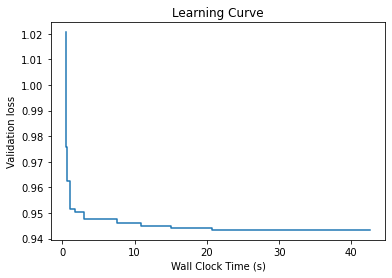

In [42]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='.segment_automl_0.5h.log', time_budget=60)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation loss")
plt.step(time_history, np.array(best_valid_loss_history), where="post")
plt.show()

학습에 영향력이 큰 피쳐

<AxesSubplot:>

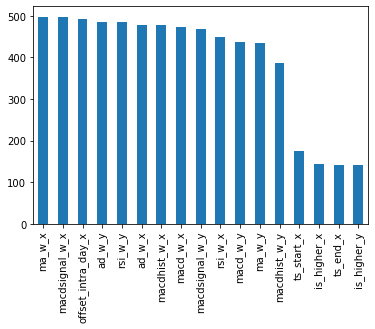

In [43]:
pd.Series(automl.feature_importances_, index=automl.feature_names_in_).sort_values(ascending=False).plot.bar()

In [44]:
from sklearn.metrics import classification_report

In [45]:
report = classification_report(y_test, y_pred)

In [46]:
print(report)

              precision    recall  f1-score   support

         NOP       0.85      0.99      0.92     13338
           X       0.46      0.07      0.13      1068
           Y       0.44      0.04      0.07      1549

    accuracy                           0.84     15955
   macro avg       0.58      0.37      0.37     15955
weighted avg       0.78      0.84      0.78     15955



예측 결과 저장

In [47]:
pd.Series(y_pred, index=y_test.index).astype('category').to_pickle('.y_pred_10m.pkl')